In [2]:
# ==================================================================================
# === SCRIPT: ENSEMBLE UNCERTAINTY-GUIDED PSEUDO-LABELING (UG-SSL) =================
# ==================================================================================

# --- 1. Import Libraries ---
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import shutil
import gc

# --- 2. FULL CONFIGURATION ---

# --- Paths ---
# Path to the FOLDER containing your 5 best .pth model files from the CV run.
TEACHER_MODELS_DIR = '/kaggle/input/best-5-folds-best-mean-dice/BEST_5_FOLDS_BEST_MEAN_DICE/'

# Path to the FOLDER containing your large pool of unlabeled images.
UNLABELED_IMAGES_DIR = '/kaggle/input/bronze-new-standard-5300/PSEUDO_LABELS/images965/'

# Destination for the new, high-quality "Platinum" dataset.
PLATINUM_IMAGES_DIR = '/kaggle/working/platinum_dataset/images/'
PLATINUM_MASKS_DIR = '/kaggle/working/platinum_dataset/masks/'

# --- Model & Image Parameters (MUST match your teacher models) ---
IMG_HEIGHT = 320
IMG_WIDTH = 320
ENCODER = 'resnext50_32x4d' # The backbone of your best models
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # Use a larger batch size for faster inference

# --- UG-SSL HYPERPARAMETERS ---
# We no longer need multiple passes (NUM_INFERENCE_PASSES) because the ensemble itself provides the variance.
UNCERTAINTY_THRESHOLD = 0.02 # Variance is a smaller number than confidence. Start with a low value.
BINARY_THRESHOLD = 0.5

# ==============================================================================
# === STEP 1: SETUP & ENSEMBLE MODEL LOADING ===================================
# ==============================================================================

print("--- Step 1: Setting up environment and loading the 'teacher' ensemble ---")
os.makedirs(PLATINUM_IMAGES_DIR, exist_ok=True)
os.makedirs(PLATINUM_MASKS_DIR, exist_ok=True)

# Find all model files in the directory
model_paths = [os.path.join(TEACHER_MODELS_DIR, f) for f in os.listdir(TEACHER_MODELS_DIR) if f.endswith('.pth')]

if len(model_paths) == 0:
    raise FileNotFoundError(f"No .pth model files found in {TEACHER_MODELS_DIR}")

print(f"Found {len(model_paths)} teacher models to create the ensemble.")

# Load all models into a list
teacher_ensemble = []
for path in model_paths:
    model = smp.UnetPlusPlus(encoder_name=ENCODER, encoder_weights=None, in_channels=1, classes=1).to(DEVICE)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.eval() # Set to evaluation mode (disables dropout)
    teacher_ensemble.append(model)
    
print("✓ Teacher ensemble loaded successfully.")

# ==============================================================================
# === STEP 2: DATASET & DATALOADER FOR UNLABELED IMAGES ========================
# ==============================================================================
# (This part remains the same)

inference_augs = A.Compose([A.Resize(IMG_HEIGHT, IMG_WIDTH), A.Normalize(mean=(0.5,), std=(0.5,)), ToTensorV2()])

class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir, self.image_ids, self.transform = image_dir, os.listdir(image_dir), transform
    def __len__(self): return len(self.image_ids)
    def __getitem__(self, idx):
        filename = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=-1)
        if self.transform: image = self.transform(image=image)['image']
        return image, filename

unlabeled_dataset = UnlabeledDataset(UNLABELED_IMAGES_DIR, transform=inference_augs)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✓ Found {len(unlabeled_dataset)} images to process.")

# ==============================================================================
# === STEP 3: ENSEMBLE UNCERTAINTY-GUIDED GENERATION LOOP ======================
# ==============================================================================

print(f"\\n--- Step 3: Starting Ensemble UG-SSL Generation ---")
print(f"Uncertainty (variance) threshold set to: {UNCERTAINTY_THRESHOLD}")

high_certainty_count = 0
total_images = 0

with torch.no_grad():
    for images, filenames in tqdm(unlabeled_loader, desc="Processing Batches"):
        images = images.to(DEVICE)
        
        batch_predictions = []
        # --- Get a prediction from each model in the ensemble ---
        for model in teacher_ensemble:
            pred_prob = torch.sigmoid(model(images))
            batch_predictions.append(pred_prob.cpu().numpy())
            
        # Stack predictions: (num_models, batch_size, channels, H, W)
        predictions_stack = np.stack(batch_predictions)
        
        # --- Calculate Uncertainty across the ENSEMBLE axis ---
        mean_predictions = predictions_stack.mean(axis=0)
        variance_maps = predictions_stack.var(axis=0)
        
        # Calculate a single uncertainty score per image in the batch
        average_uncertainties = variance_maps.mean(axis=(1, 2, 3))
        
        # --- Process each image in the batch ---
        for i in range(len(filenames)):
            total_images += 1
            uncertainty_score = average_uncertainties[i]
            
            # --- The Filtering Decision ---
            if uncertainty_score < UNCERTAINTY_THRESHOLD:
                high_certainty_count += 1
                
                filename = filenames[i]
                
                # Copy the original image
                source_image_path = os.path.join(UNLABELED_IMAGES_DIR, filename)
                dest_image_path = os.path.join(PLATINUM_IMAGES_DIR, filename)
                shutil.copy(source_image_path, dest_image_path)
                
                # Save the ENSEMBLE MEAN prediction as the new mask
                mean_mask = (mean_predictions[i].squeeze() > BINARY_THRESHOLD).astype(np.uint8) * 255
                dest_mask_path = os.path.join(PLATINUM_MASKS_DIR, filename)
                cv2.imwrite(dest_mask_path, mean_mask)

# ==============================================================================
# === STEP 4: FINAL REPORT & ARCHIVING =========================================
# ==============================================================================

print(f"\\n--- UG-SSL Process Complete! ---")
print(f"Processed {total_images} unlabeled images.")
print(f"Found and saved {high_certainty_count} high-certainty (low-uncertainty) 'Platinum' labels.")
print(f"Your new dataset is ready in: {os.path.dirname(PLATINUM_IMAGES_DIR)}")

# --- ARCHIVE THE RESULTS INTO A ZIP FILE ---
print("\\n--- Archiving the new Platinum dataset into a ZIP file ---")
output_filename = 'platinum_dataset'
directory_to_zip = os.path.dirname(PLATINUM_IMAGES_DIR)

try:
    shutil.make_archive(output_filename, 'zip', directory_to_zip)
    print(f"\\n--- SUCCESS! ---")
    print(f"Dataset has been saved to '{output_filename}.zip'")
    print("You can now find this file in the '/kaggle/working/' output section and download it.")
except Exception as e:
    print(f"\\n--- ERROR: Could not create ZIP file. --- Details: {e}")

# Clean up memory
del teacher_ensemble
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

--- Step 1: Setting up environment and loading the 'teacher' ensemble ---
Found 5 teacher models to create the ensemble.
✓ Teacher ensemble loaded successfully.
✓ Found 5607 images to process.
\n--- Step 3: Starting Ensemble UG-SSL Generation ---
Uncertainty (variance) threshold set to: 0.02


Processing Batches:   0%|          | 0/351 [00:00<?, ?it/s]

\n--- UG-SSL Process Complete! ---
Processed 5607 unlabeled images.
Found and saved 5576 high-certainty (low-uncertainty) 'Platinum' labels.
Your new dataset is ready in: /kaggle/working/platinum_dataset/images
\n--- Archiving the new Platinum dataset into a ZIP file ---
\n--- SUCCESS! ---
Dataset has been saved to 'platinum_dataset.zip'
You can now find this file in the '/kaggle/working/' output section and download it.


In [1]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.2 MB/s eta 0:00:00:00:0100:01
  Attempting un

In [3]:
# --- SCRIPT TO ZIP ONLY THE MASKS FOLDER ---

import os
import shutil

print("--- Archiving ONLY the MASKS folder into a ZIP file ---")

# --- 1. CONFIGURATION ---
# The path to the folder containing your final platinum masks
MASKS_TO_ZIP_DIR = '/kaggle/working/platinum_dataset/masks/'

# The name for the output zip file
output_filename = 'platinum_masks' 

# --- 2. THE SCRIPT ---
try:
    # Check if the directory exists
    if os.path.isdir(MASKS_TO_ZIP_DIR):
        shutil.make_archive(output_filename, 'zip', MASKS_TO_ZIP_DIR)
        print(f"\\n--- SUCCESS! ---")
        print(f"All files in '{MASKS_TO_ZIP_DIR}' have been saved to '{output_filename}.zip'")
        print("You can now find this file in the 'Output' section and download it.")
    else:
        print(f"--- ERROR: Directory not found: {MASKS_TO_ZIP_DIR} ---")

except Exception as e:
    print(f"\\n--- ERROR: Could not create ZIP file. ---")
    print(f"Details: {e}")

--- Archiving ONLY the MASKS folder into a ZIP file ---
\n--- SUCCESS! ---
All files in '/kaggle/working/platinum_dataset/masks/' have been saved to 'platinum_masks.zip'
You can now find this file in the 'Output' section and download it.


--- Part 1: Generating Predictions and Calculating Uncertainty Scores ---
✓ Loaded 5 teacher models.
✓ Found 5607 images to process.


Step 1/2: Predicting:   0%|          | 0/351 [00:00<?, ?it/s]

✓ Prediction and uncertainty calculation complete.

--- Part 2: Analyzing Uncertainty Distribution ---


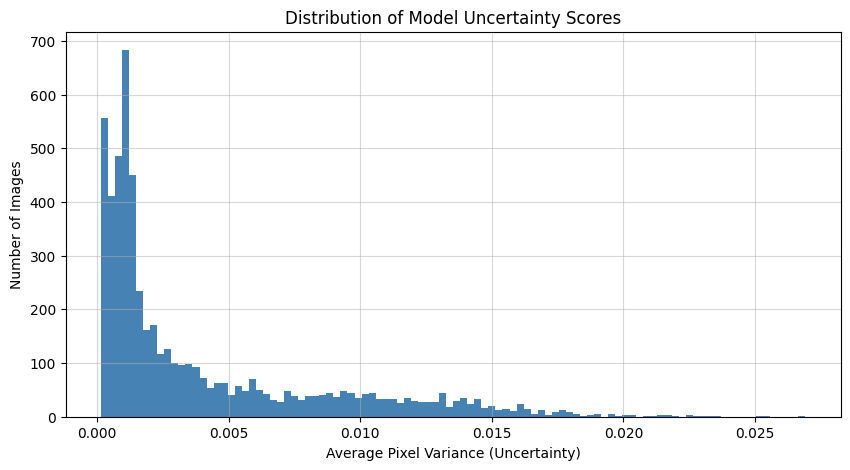


--- Uncertainty Statistics ---
count    5607.000000
mean        0.004028
std         0.004587
min         0.000151
25%         0.000925
50%         0.001726
75%         0.005841
max         0.026914
Name: uncertainty, dtype: float64
\nTo get ~1000 images, your threshold should be around: 7.2380e-04
\n--- Part 3: Filtering with final threshold: 7.2380e-04 ---
Found 1000 high-certainty images to save.


Step 2/2: Saving Files:   0%|          | 0/1000 [00:00<?, ?it/s]

\n--- Filtering and saving complete! ---
\n--- Archiving the final Platinum dataset into a ZIP file ---
\n--- SUCCESS! ---
Dataset has been saved to 'platinum_dataset_1000_images.zip'


In [5]:
# ==================================================================================
# === FINAL, ROBUST SCRIPT: UNCERTAINTY ANALYSIS & FILTERING =====================
# ==================================================================================

import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import shutil
import gc
from matplotlib import pyplot as plt

# --- 1. CONFIGURATION ---
TEACHER_MODELS_DIR = '/kaggle/input/best-5-folds-best-mean-dice/BEST_5_FOLDS_BEST_MEAN_DICE/'
UNLABELED_IMAGES_DIR = '/kaggle/input/bronze-new-standard-5300/PSEUDO_LABELS/images965/'

# --- We will save ALL intermediate results to the working directory ---
TEMP_PROB_MASKS_DIR = '/kaggle/working/temp_prob_masks/' # To store raw probabilities

# --- Model & Image Parameters ---
IMG_HEIGHT = 320
IMG_WIDTH = 320
ENCODER = 'resnext50_32x4d'
DEVICE = "cuda"
BATCH_SIZE = 16

# ==============================================================================
# === PART 1: GENERATE ALL PREDICTIONS AND CALCULATE UNCERTAINTY ==============
# ==============================================================================

print("--- Part 1: Generating Predictions and Calculating Uncertainty Scores ---")
os.makedirs(TEMP_PROB_MASKS_DIR, exist_ok=True)

# --- Load the Ensemble of Teacher Models (same as before) ---
model_paths = [os.path.join(TEACHER_MODELS_DIR, f) for f in os.listdir(TEACHER_MODELS_DIR) if f.endswith('.pth')]
teacher_ensemble = []
for path in model_paths:
    model = smp.UnetPlusPlus(encoder_name=ENCODER, encoder_weights=None, in_channels=1, classes=1).to(DEVICE)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.eval()
    teacher_ensemble.append(model)
print(f"✓ Loaded {len(teacher_ensemble)} teacher models.")


inference_augs = A.Compose([A.Resize(IMG_HEIGHT, IMG_WIDTH), A.Normalize(mean=(0.5,), std=(0.5,)), ToTensorV2()])

class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir, self.image_ids, self.transform = image_dir, os.listdir(image_dir), transform
    def __len__(self): return len(self.image_ids)
    def __getitem__(self, idx):
        filename = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=-1)
        if self.transform: image = self.transform(image=image)['image']
        return image, filename


unlabeled_dataset = UnlabeledDataset(UNLABELED_IMAGES_DIR, transform=inference_augs)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✓ Found {len(unlabeled_dataset)} images to process.")

uncertainty_scores = []
filenames_list = []

with torch.no_grad():
    for images, filenames in tqdm(unlabeled_loader, desc="Step 1/2: Predicting"):
        images = images.to(DEVICE)
        batch_predictions = []
        for model in teacher_ensemble:
            pred_prob = torch.sigmoid(model(images))
            batch_predictions.append(pred_prob.cpu().numpy())
        
        predictions_stack = np.stack(batch_predictions)
        variance_maps = predictions_stack.var(axis=0)
        average_uncertainties = variance_maps.mean(axis=(1, 2, 3))
        
        # Save the MEAN prediction for later use
        mean_predictions = predictions_stack.mean(axis=0)
        for i in range(len(filenames)):
            filename = filenames[i]
            # Save the mean probability map as a .npy file
            np.save(os.path.join(TEMP_PROB_MASKS_DIR, f"{os.path.splitext(filename)[0]}.npy"), mean_predictions[i])
        
        uncertainty_scores.extend(average_uncertainties)
        filenames_list.extend(filenames)

# Create a DataFrame with filenames and their uncertainty scores
results_df = pd.DataFrame({
    'filename': filenames_list,
    'uncertainty': uncertainty_scores
})

print("✓ Prediction and uncertainty calculation complete.")

# ==============================================================================
# === PART 2: ANALYZE UNCERTAINTY AND CHOOSE A THRESHOLD =======================
# ==============================================================================

print("\n--- Part 2: Analyzing Uncertainty Distribution ---")

# Plot a histogram of the uncertainty scores
plt.figure(figsize=(10, 5))
plt.hist(results_df['uncertainty'], bins=100, color='steelblue')
plt.title('Distribution of Model Uncertainty Scores')
plt.xlabel('Average Pixel Variance (Uncertainty)')
plt.ylabel('Number of Images')
plt.grid(True, alpha=0.5)
plt.show()

print("\n--- Uncertainty Statistics ---")
print(results_df['uncertainty'].describe())

# --- Interactive Threshold Selection ---
# Let's find a threshold that gives us ~1000-2000 images
quantile_for_1000 = results_df['uncertainty'].quantile(q=1000/len(results_df))
print(f"\\nTo get ~1000 images, your threshold should be around: {quantile_for_1000:.4e}")

# SET YOUR FINAL THRESHOLD HERE
FINAL_UNCERTAINTY_THRESHOLD = quantile_for_1000 # Start with this value

# ==============================================================================
# === PART 3: FILTER, SAVE, AND ZIP THE FINAL DATASET ==========================
# ==============================================================================

print(f"\\n--- Part 3: Filtering with final threshold: {FINAL_UNCERTAINTY_THRESHOLD:.4e} ---")

PLATINUM_IMAGES_DIR = '/kaggle/working/platinum_dataset/images/'
PLATINUM_MASKS_DIR = '/kaggle/working/platinum_dataset/masks/'
os.makedirs(PLATINUM_IMAGES_DIR, exist_ok=True)
os.makedirs(PLATINUM_MASKS_DIR, exist_ok=True)

# Select the filenames of the high-certainty images
high_certainty_df = results_df[results_df['uncertainty'] < FINAL_UNCERTAINTY_THRESHOLD]

print(f"Found {len(high_certainty_df)} high-certainty images to save.")

for _, row in tqdm(high_certainty_df.iterrows(), total=len(high_certainty_df), desc="Step 2/2: Saving Files"):
    filename = row['filename']
    
    # Copy original image
    shutil.copy(os.path.join(UNLABELED_IMAGES_DIR, filename), os.path.join(PLATINUM_IMAGES_DIR, filename))
    
    # Load the saved mean probability mask and save it as a binary PNG
    prob_mask = np.load(os.path.join(TEMP_PROB_MASKS_DIR, f"{os.path.splitext(filename)[0]}.npy"))
    final_mask = (prob_mask.squeeze() > 0.5).astype(np.uint8) * 255
    cv2.imwrite(os.path.join(PLATINUM_MASKS_DIR, filename), final_mask)

print("\\n--- Filtering and saving complete! ---")

print("\\n--- Archiving the final Platinum dataset into a ZIP file ---")
output_filename = 'platinum_dataset_1000_images' # A descriptive name
directory_to_zip = '/kaggle/working/platinum_dataset/' # The CORRECT parent folder

try:
    shutil.make_archive(output_filename, 'zip', directory_to_zip)
    print(f"\\n--- SUCCESS! ---")
    print(f"Dataset has been saved to '{output_filename}.zip'")
except Exception as e:
    print(f"\\n--- ERROR creating ZIP file: {e}")

In [6]:
# ==============================================================================
# === FINAL, SIMPLE, AND CORRECT UG-SSL SCRIPT ===============================
# ==============================================================================

# --- 1. Imports ---
import os, cv2, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import shutil, gc

# --- 2. Configuration ---
# All paths must be explicit and correct.
TEACHER_MODELS_DIR = '/kaggle/input/best-5-folds-best-mean-dice/BEST_5_FOLDS_BEST_MEAN_DICE/'
UNLABELED_IMAGES_DIR = '/kaggle/input/bronze-new-standard-5300/PSEUDO_LABELS/images965/'
OUTPUT_DIR = '/kaggle/working/platinum_dataset_final/' # A single, new output folder

# Model & Image Parameters
IMG_SIZE = 320
ENCODER = 'resnext50_32x4d'
DEVICE = "cuda"
BATCH_SIZE = 16

# --- 3. The Unlabeled Dataset Class (Simple and Correct) ---
inference_augs = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(mean=(0.5,), std=(0.5,)), ToTensorV2()])
class UnlabeledDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_ids = os.listdir(image_dir)
    def __len__(self): return len(self.image_ids)
    def __getitem__(self, idx):
        filename = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=-1)
        transformed = inference_augs(image=image)
        return transformed['image'], filename

# ==============================================================================
# === PART 1: PREDICT AND CALCULATE UNCERTAINTY ================================
# ==============================================================================
print("--- Part 1: Generating Predictions and Uncertainty Scores ---")

# --- Load Ensemble ---
model_paths = [os.path.join(TEACHER_MODELS_DIR, f) for f in os.listdir(TEACHER_MODELS_DIR) if f.endswith('.pth')]
teacher_ensemble = []
for path in model_paths:
    model = smp.UnetPlusPlus(encoder_name=ENCODER, encoder_weights=None, in_channels=1, classes=1).to(DEVICE)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.eval()
    teacher_ensemble.append(model)
print(f"✓ Loaded {len(teacher_ensemble)} teacher models.")

# --- Create Dataloader ---
unlabeled_dataset = UnlabeledDataset(UNLABELED_IMAGES_DIR)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

results_data = [] # To store {'filename': ..., 'uncertainty': ...}

with torch.no_grad():
    for images, filenames in tqdm(unlabeled_loader, desc="Predicting"):
        images = images.to(DEVICE)
        
        batch_predictions = []
        for model in teacher_ensemble:
            pred_prob = torch.sigmoid(model(images))
            batch_predictions.append(pred_prob.cpu().numpy())
            
        predictions_stack = np.stack(batch_predictions)
        variance_maps = predictions_stack.var(axis=0)
        average_uncertainties = variance_maps.mean(axis=(1, 2, 3))
        
        # We also need the mean prediction to save later
        mean_predictions = predictions_stack.mean(axis=0)
        
        for i in range(len(filenames)):
            results_data.append({
                'filename': filenames[i],
                'uncertainty': average_uncertainties[i],
                'mean_pred': mean_predictions[i] # Store the mean prediction array
            })

results_df = pd.DataFrame(results_data)
print(f"✓ Calculated uncertainty for {len(results_df)} images.")

# ==============================================================================
# === PART 2: ANALYZE AND FILTER ===============================================
# ==============================================================================
print("\n--- Part 2: Analyzing and Filtering ---")

# --- Find the threshold for the top N images ---
# Let's aim for a slightly larger, high-quality set
NUM_IMAGES_TO_KEEP = 1500
if len(results_df) > NUM_IMAGES_TO_KEEP:
    # Sort by uncertainty and find the threshold of the Nth image
    results_df = results_df.sort_values('uncertainty', ascending=True)
    uncertainty_threshold = results_df.iloc[NUM_IMAGES_TO_KEEP - 1]['uncertainty']
    # Select all images with uncertainty less than or equal to this threshold
    high_certainty_df = results_df[results_df['uncertainty'] <= uncertainty_threshold]
else:
    high_certainty_df = results_df

print(f"Uncertainty threshold set to keep the best {len(high_certainty_df)} images.")

# ==============================================================================
# === PART 3: SAVE THE FINAL DATASET AND ZIP IT ================================
# ==============================================================================
print("\n--- Part 3: Saving Final 'Platinum' Dataset ---")

# Define final output paths
PLATINUM_IMAGES_DIR = os.path.join(OUTPUT_DIR, 'images')
PLATINUM_MASKS_DIR = os.path.join(OUTPUT_DIR, 'masks')
os.makedirs(PLATINUM_IMAGES_DIR, exist_ok=True)
os.makedirs(PLATINUM_MASKS_DIR, exist_ok=True)

for _, row in tqdm(high_certainty_df.iterrows(), total=len(high_certainty_df), desc="Saving Files"):
    filename = row['filename']
    
    # --- Source and Destination Paths ---
    source_image_path = os.path.join(UNLABELED_IMAGES_DIR, filename)
    dest_image_path = os.path.join(PLATINUM_IMAGES_DIR, filename)
    
    dest_mask_path = os.path.join(PLATINUM_MASKS_DIR, filename)
    
    # --- Copy the original image ---
    shutil.copy(source_image_path, dest_image_path)
    
    # --- Save the binarized mean prediction as the mask ---
    mean_pred_mask = row['mean_pred']
    binary_mask = (mean_pred_mask.squeeze() > 0.5).astype(np.uint8) * 255
    cv2.imwrite(dest_mask_path, binary_mask)

print(f"✓ Saved {len(high_certainty_df)} image/mask pairs to {OUTPUT_DIR}")

# --- Final Archiving Step ---
print("\n--- Archiving the final dataset into a ZIP file ---")
output_zip_name = 'platinum_dataset_final'

try:
    shutil.make_archive(output_zip_name, 'zip', OUTPUT_DIR)
    print(f"\\n--- SUCCESS! ---")
    print(f"Dataset has been saved to '{output_zip_name}.zip'")
except Exception as e:
    print(f"\\n--- ERROR creating ZIP file: {e}")

# --- Clean up memory ---
del teacher_ensemble, results_df, high_certainty_df
gc.collect()
torch.cuda.empty_cache()

--- Part 1: Generating Predictions and Uncertainty Scores ---
✓ Loaded 5 teacher models.


Predicting:   0%|          | 0/351 [00:00<?, ?it/s]

✓ Calculated uncertainty for 5607 images.

--- Part 2: Analyzing and Filtering ---
Uncertainty threshold set to keep the best 1500 images.

--- Part 3: Saving Final 'Platinum' Dataset ---


Saving Files:   0%|          | 0/1500 [00:00<?, ?it/s]

✓ Saved 1500 image/mask pairs to /kaggle/working/platinum_dataset_final/

--- Archiving the final dataset into a ZIP file ---
\n--- SUCCESS! ---
Dataset has been saved to 'platinum_dataset_final.zip'
